In [1]:
import os
import sys
import scipy as sp
import numpy as np
import astropy as ap
import pandas as pd
import matplotlib as mpl
from matplotlib import colormaps
import matplotlib.pyplot as plt
import astropy.cosmology as apc
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import fitsio
import kcorrect
import kmeans_radec as kr
from scipy.optimize import curve_fit, leastsq
from tqdm import tqdm
import seaborn as sns

H0 = 100
Om0=0.3065
Ode0 = 1-Om0
sch_c = 2.99792458e5
cosmo = FlatLambdaCDM(H0=100, Om0=0.3065)

In [23]:
sns.set_theme('talk',rc={"legend.fontsize": 13})
sns.set_style('white', {'xtick.bottom':True, 'ytick.left':True})
sns.plotting_context('talk',rc={"legend.fontsize": 13})

{'axes.linewidth': 1.875,
 'grid.linewidth': 1.5,
 'lines.linewidth': 2.25,
 'lines.markersize': 9.0,
 'patch.linewidth': 1.5,
 'xtick.major.width': 1.875,
 'ytick.major.width': 1.875,
 'xtick.minor.width': 1.5,
 'ytick.minor.width': 1.5,
 'xtick.major.size': 9.0,
 'ytick.major.size': 9.0,
 'xtick.minor.size': 6.0,
 'ytick.minor.size': 6.0,
 'font.size': 18.0,
 'axes.labelsize': 18.0,
 'axes.titlesize': 18.0,
 'xtick.labelsize': 16.5,
 'ytick.labelsize': 16.5,
 'legend.fontsize': 13,
 'legend.title_fontsize': 18.0}

In [3]:
def lumdist(z):
    '''
    Calculates the luminosity distance based on given redshift. Uses cubic spline to approximate the result.

    Arguments:
        z: The redshift should be input as a Numpy array

    '''
    z = np.array(z)
    z_max = z.max()

    reds = np.linspace(0,z_max,1000)
    zez = []
    for i in reds:
        zaz = sp.integrate.quad(lambda x:(1/np.sqrt(Om0*(1+x)**3 + Ode0)), 0, i)[0]
        zez.append(zaz)

    return (1+z) * 2.99792458*10**5/H0 * sp.interpolate.interp1d(reds, zez)(z)

def lumdist_err(z,z_err):
    '''
    Calculates the associated upper and lower luminosity distance error based on the given redshift and associated error. 
    The reason for separate errors is that since redshift isn't linearly related to luminosity distance, the transformation doesn't result in the same amount of error.

    Arguments:
        Input: Should be given as a Numpy array
        Output: Numpy array in the form [lower error, upper error]
    
    '''
    z = np.array(z)
    z_err = np.array(z_err)
    
    lowerr = lumdist(z) - lumdist(z-z_err)
    uperr = lumdist(z+z_err) - lumdist(z)

    return np.array([lowerr,uperr])

def z_from_dl(dl):
    '''
    Returns the redshift based on the given luminosity distance in units of Mpc.

    Arguments:
        dl: The luminosity distance should be input as a Numpy array
    
    '''
    dl = np.array(dl)
    reds = np.linspace(0,10,1000)
    zez = []
    for i in reds:
        zaz = (1+i) * 2.99792458*10**5/H0 * sp.integrate.quad(lambda x:(1/np.sqrt(Om0*(1+x)**3 + Ode0)), 0, i)[0]
        zez.append(zaz)

    return sp.interpolate.CubicSpline(zez,reds)(dl)

In [4]:
df = pd.read_csv("~/Desktop/MT/master_test/NYU_VAGC_nearest_petro_00.csv")

df = df.drop(columns='Unnamed: 0')

magmask = (df[[f"maggies_{i}" for i in 'ugriz']] >= 0.).all(axis=1)

ivarmask = (df[[f"ivar_{j}" for j in 'ugriz']] >= 1e10).all(axis=1)

zmaskh = df['redshift'] > 1e-6

zmaskl = df['redshift'] <= 0.5

mask_total = magmask & zmaskh & ivarmask & zmaskl

In [5]:
df1 = df[mask_total]

df1.columns

Index(['redshift', 'k_u', 'k_g', 'k_r', 'k_i', 'k_z', 'M_u', 'M_g', 'M_r',
       'M_i', 'M_z', 'Stellar_Mass', 'maggies_u', 'maggies_g', 'maggies_r',
       'maggies_i', 'maggies_z', 'ivar_u', 'ivar_g', 'ivar_r', 'ivar_i',
       'ivar_z', 'coeffs_u', 'coeffs_g', 'coeffs_r', 'coeffs_i', 'coeffs_z',
       'RA', 'DEC'],
      dtype='object')

In [6]:
ra = df1['RA'].to_numpy()
dec = df1['DEC'].to_numpy()

# DATA LOADER

In [7]:
# data loading for objects
test = df1[:] # iloc = index location ; syntax are [row, columns] => deprecated

x = len(test)

_ktest = [f'k_{i}' for i in 'ugriz']
k_test = test[_ktest].to_numpy().T

_absmag_test = [f'M_{i}' for i in 'ugriz']
absmag_test = test[_absmag_test].to_numpy().T

redshift = test['redshift']

_maggies = [f'maggies_{i}' for i in 'ugriz']
maggies = test[_maggies]

_ivar = [f'ivar_{i}' for i in 'ugriz']
ivar = test[_ivar]

_coeffs = [f'coeffs_{i}' for i in 'ugriz']
coeffs1 = test[_coeffs]

dl = lumdist(redshift)
DM = 5*np.log10(dl) + 25
DM = np.broadcast_to(DM.reshape(-1,1), (x,5))

In [8]:
appmag = -2.5*np.log10(maggies.to_numpy())

fluxerr = np.sqrt(ivar**-1)

appmag_err = (2.5/np.log(10)/maggies.to_numpy()) * fluxerr.to_numpy()

# Kcorrect Test

In [9]:
responses = ['sdss_u0', 'sdss_g0','sdss_r0','sdss_i0','sdss_z0']
kz = kcorrect.kcorrect.Kcorrect(responses=responses,cosmo=cosmo)

In [10]:
coeffs = kz.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivar)

In [11]:
# getting k corrections
K = kz.kcorrect(redshift=redshift, coeffs=coeffs).T

M_k = kz.absmag(redshift=redshift, maggies=maggies, ivar=ivar, coeffs=coeffs).T

In [12]:
M = (appmag.T - K - DM.T)
M_err = np.sqrt(appmag_err**2).T

In [13]:
ran1 = (redshift > 0.0) & (redshift <= 0.1)
ran2 = (redshift > 0.1) & (redshift <= 0.2)
ran3 = (redshift > 0.2) & (redshift <= 0.3)
ran4 = (redshift > 0.3) & (redshift <= 0.4)
ran5 = (redshift > 0.4) & (redshift <= 0.5)

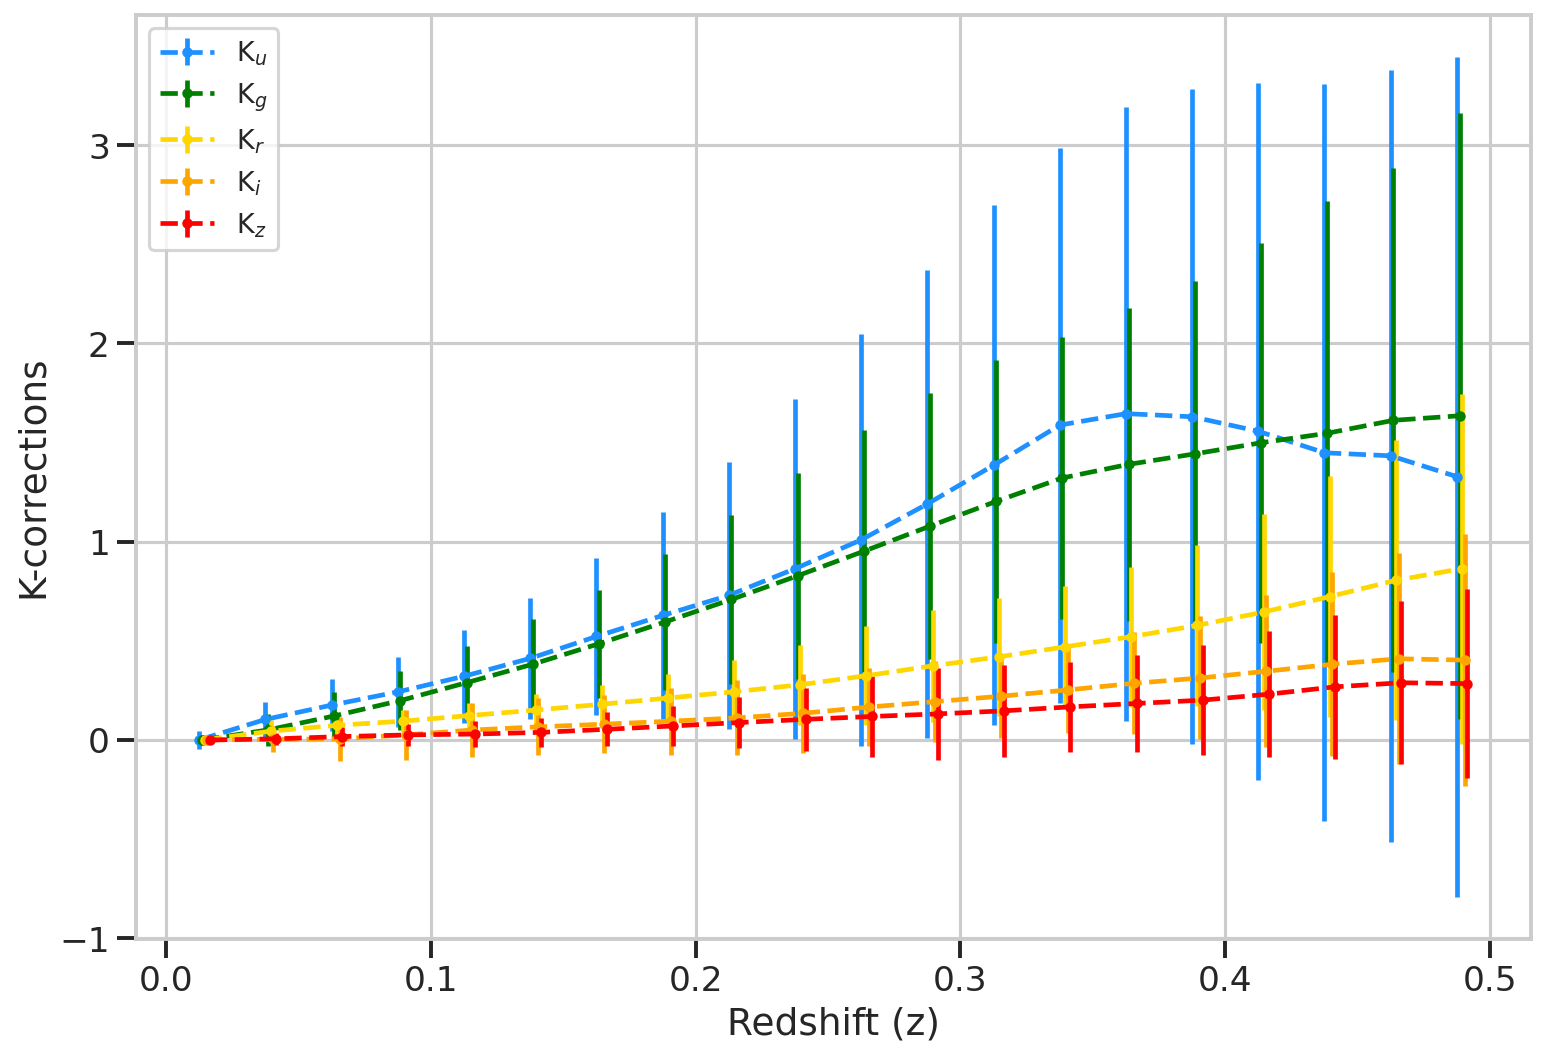

In [14]:
gedges = np.linspace(0,0.5,21)
hedges = 0.5*(gedges[1:]+gedges[:-1])

fig, ax = plt.subplots(figsize=(12,8),dpi=150)
longmed = []
longstd = []
names = ['u','g','r','i','z']
colors = ['dodgerblue','green','gold','orange','red']
for j in range(5):
    med=[]
    std=[]
    for i in range(20):
        ranger = (redshift > gedges[i]) & (redshift <= gedges[i+1])
        med.append(np.median(K[j][ranger]))
        std.append(2*np.std(K[j][ranger]))
    longmed.append(med)
    longstd.append(std)

    ax.errorbar(hedges+j/1000,med, yerr=std,c=colors[j],marker='o',markersize=4,label=f'K$_{{{names[j]}}}$',ls='--')

ax.set_ylabel('K-corrections')
ax.set_xlabel('Redshift (z)')
fig.legend(loc='upper left', bbox_to_anchor=(0.125,0.88))
#fig.savefig('kcorr_single.png')
plt.show()

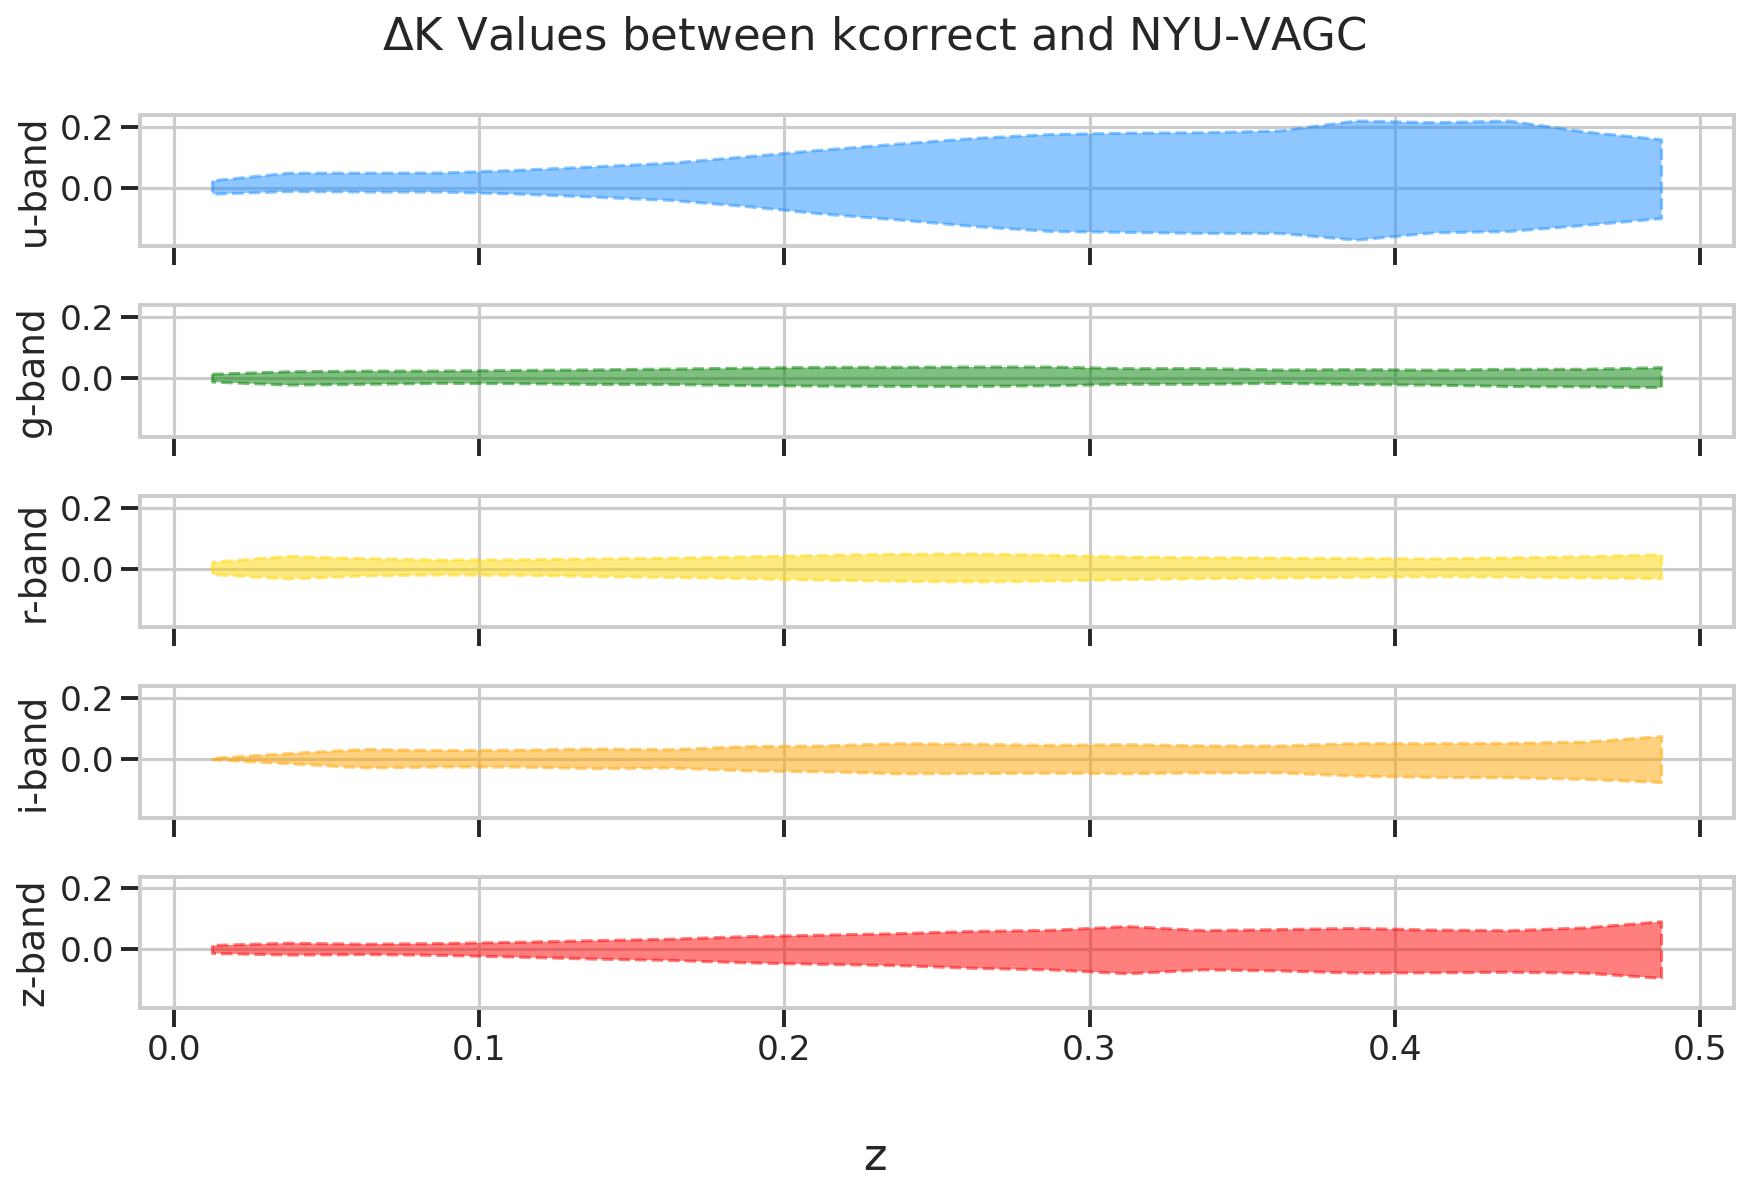

In [15]:
gedges = np.linspace(0,0.5,21)
hedges = 0.5*(gedges[1:]+gedges[:-1])

fig, ax = plt.subplots(figsize=(12,8),dpi=150,nrows=5,sharey=True,sharex=True)
longmed = []
longstd = []
names = ['u','g','r','i','z']
colors = ['dodgerblue','green','gold','orange','red']
for j in range(5):
    med=[]
    std=[]
    for i in range(20):
        ranger = (redshift > gedges[i]) & (redshift <= gedges[i+1])
        med.append(np.median(K[j][ranger]-k_test[j][ranger]))
        std.append(2*np.std(K[j][ranger]-k_test[j][ranger]))
    med=np.array(med)
    std=np.array(std)
    longmed.append(med)
    longstd.append(std)

    ax[j].fill_between(hedges,med-std,med+std,color=colors[j],alpha=0.5,label=f'{names[j]}-band',ls='--')
    ax[j].set_ylabel(f'{names[j]}-band')
fig.supxlabel('z')
fig.suptitle('$\Delta$K Values between kcorrect and NYU-VAGC')
# fig.savefig('deltak.png')
fig.tight_layout()
plt.show()

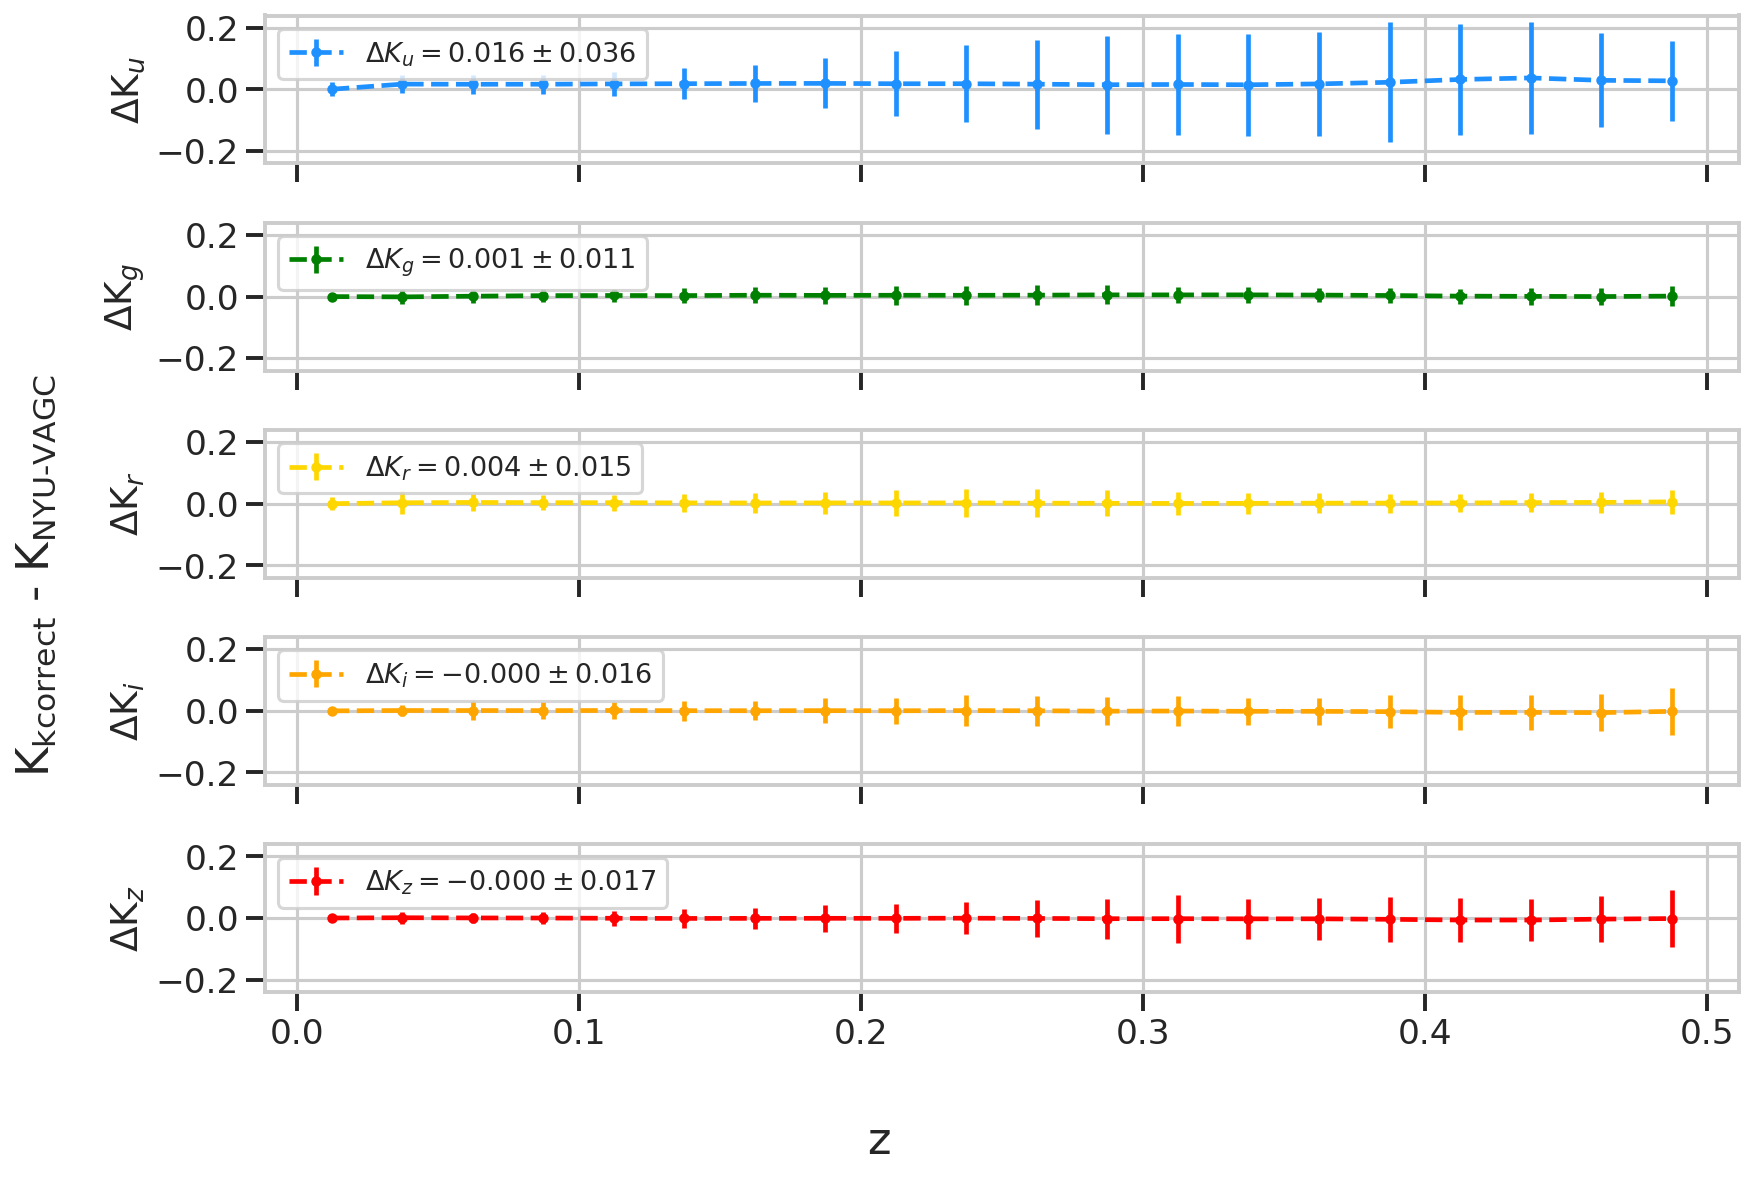

In [16]:
gedges = np.linspace(0,0.5,21)
hedges = 0.5*(gedges[1:]+gedges[:-1])

fig, ax = plt.subplots(figsize=(12,8),dpi=150,nrows=5,sharey=True,sharex=True)
longmed = []
longstd = []
names = ['u','g','r','i','z']
colors = ['dodgerblue','green','gold','orange','red']
for j in range(5):
    med=[]
    std=[]
    for i in range(20):
        ranger = (redshift > gedges[i]) & (redshift <= gedges[i+1])
        med.append(np.median(K[j][ranger]-k_test[j][ranger]))
        std.append(2*np.std(K[j][ranger]-k_test[j][ranger]))
    longmed.append(med)
    longstd.append(std)
    
    remed = np.mean(K[j]-k_test[j])
    restd = np.std(K[j]-k_test[j])

    ax[j].errorbar(hedges,med,yerr=std,c=colors[j],marker='o',markersize=4,ls='--',label=fr'$\Delta K_{names[j]} = {remed:.3f}\pm{restd:.3f}$')
    ax[j].legend(loc='upper left')
    ax[j].set_ylabel(fr'$\Delta$K$_{{{names[j]}}}$')
fig.supylabel(r'K$_{\text{kcorrect}}$ - K$_{\text{NYU-VAGC}}$')
ax[0].set_ylim(-0.24,0.24)
fig.supxlabel('z')
#fig.suptitle('$\Delta$K Values between kcorrect and NYU-VAGC')
fig.tight_layout()
#fig.savefig('deltak.png')
plt.show()

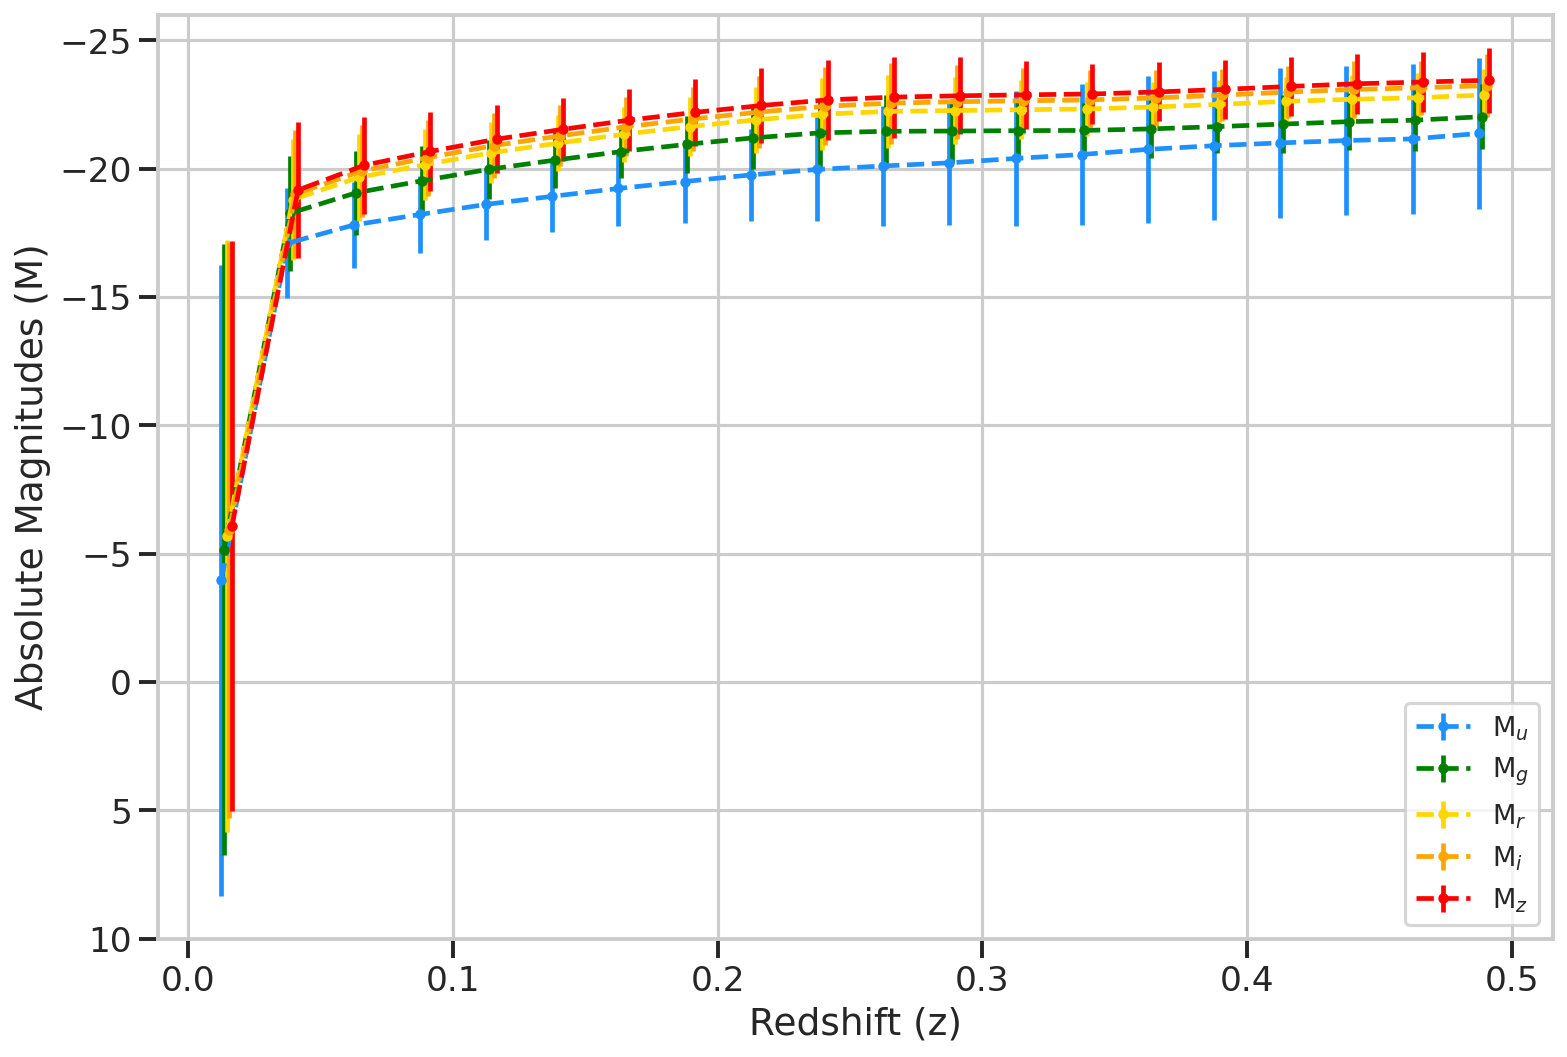

In [17]:
gedges = np.linspace(0,0.5,21)
hedges = 0.5*(gedges[1:]+gedges[:-1])
names = ['u','g','r','i','z']
colors = ['dodgerblue','green','gold','orange','red']
fig, ax = plt.subplots(figsize=(12,8),dpi=150)
for j in range(5):
    med=[]
    std=[]
    for i in range(20):
        ranger = (redshift > gedges[i]) & (redshift <= gedges[i+1])
        med.append(np.median(M[j][ranger]))
        std.append(2*np.std(M[j][ranger]))
        
    ax.errorbar(hedges+j/1000,med,yerr=std,c=colors[j],marker='o',markersize=4,label=f'M$_{{{names[j]}}}$',ls='--')

ax.set_ylim(-26,10)
ax.invert_yaxis()

ax.set_ylabel('Absolute Magnitudes (M)')
ax.set_xlabel('Redshift (z)')
fig.legend(loc='lower right', bbox_to_anchor=(0.9,0.11))
#fig.savefig('M_single.png')
plt.show()

In [18]:
axe = np.histogram2d(redshift,M[2],bins=int(np.sqrt(len(redshift))))

axe[0]/axe[0].sum()

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.38964491e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
      shape=(1031, 1031))

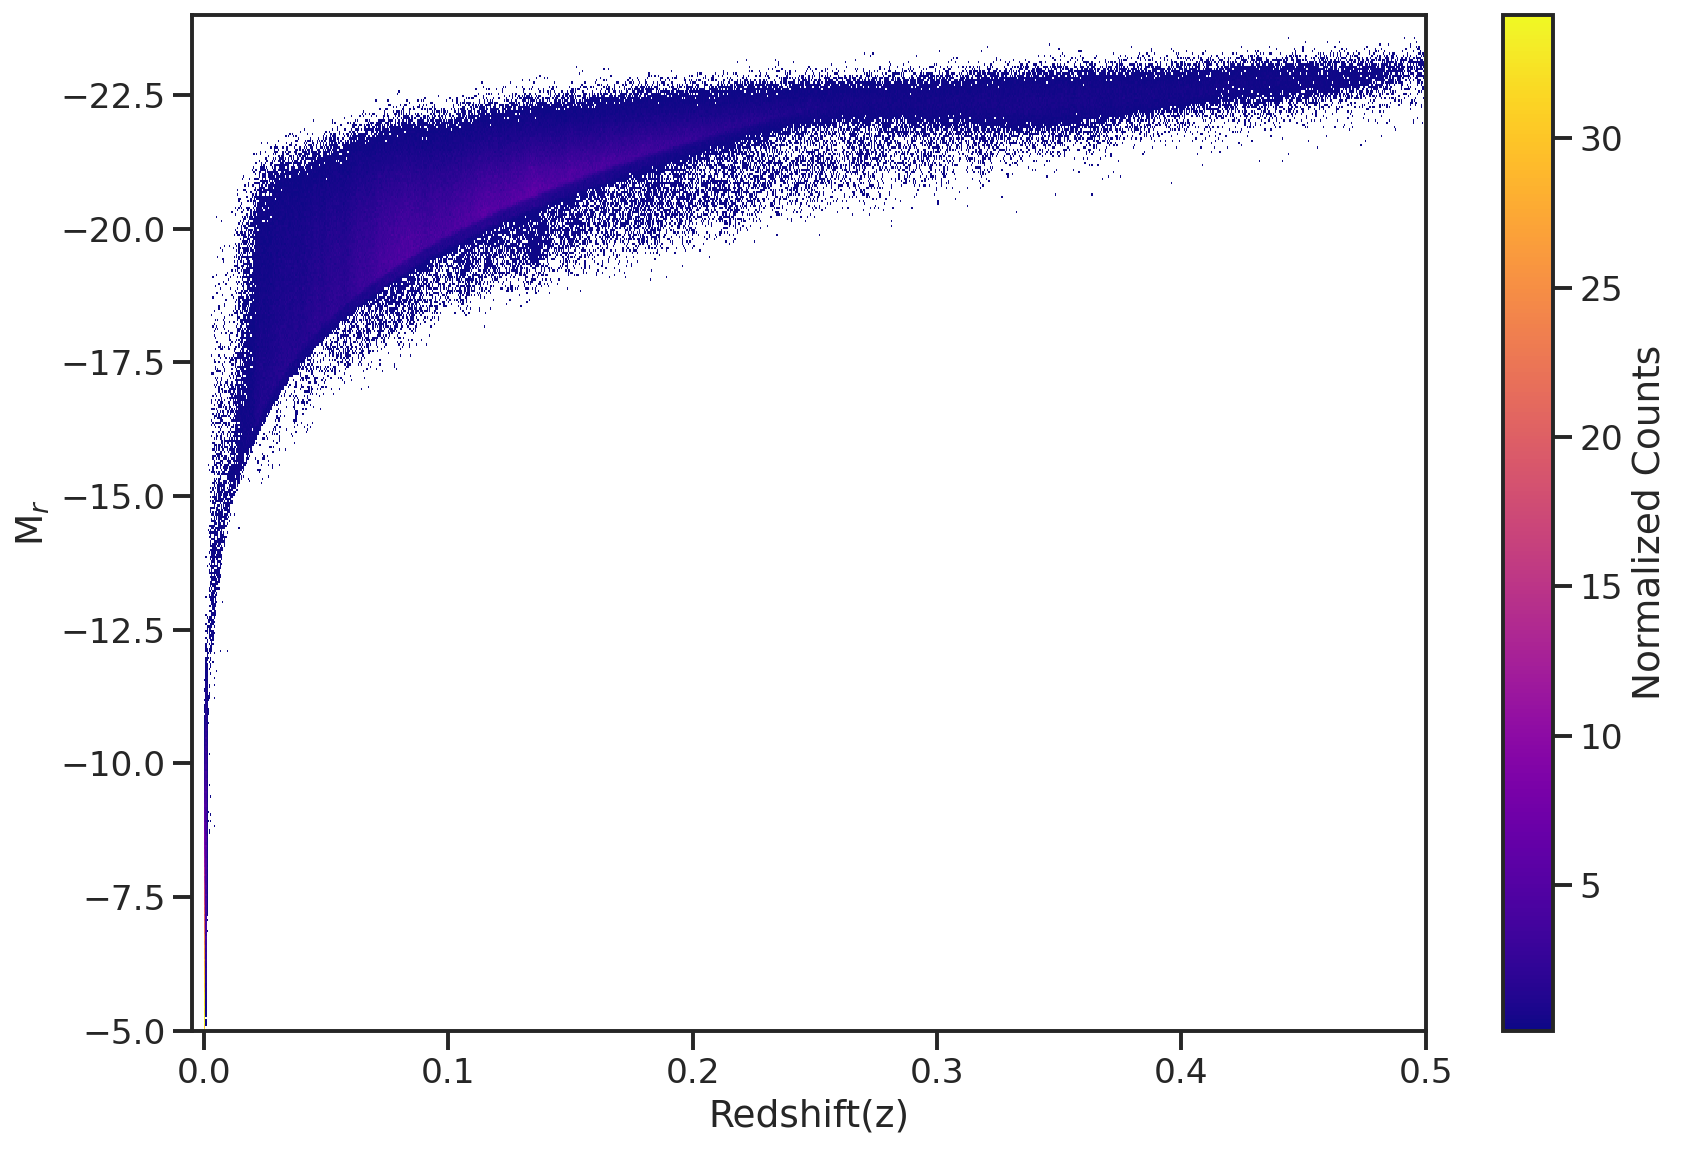

In [34]:
from copy import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

palette = copy(plt.get_cmap('plasma'))
palette.set_under('white', 1.0)

fig, ax = plt.subplots(figsize=(12,8),dpi=150)
axe = ax.hist2d(redshift,M[2],density=True,bins=int(np.sqrt(len(redshift))),cmin=.1,cmap=palette)
fig.colorbar(axe[3],ax=ax,label='Normalized Counts')
ax.set_ylim(-24,-5)
ax.set_xlim(-0.005,0.5)
ax.invert_yaxis()
ax.set_xlabel('Redshift(z)')
ax.set_ylabel(r'M$_r$')
fig.tight_layout()
#fig.savefig('M_single_dens.png')

plt.show()

In [ ]:
gedges = np.linspace(0.0033,0.5,21)
hedges = 0.5*(gedges[1:]+gedges[:-1])

fig, ax = plt.subplots(figsize=(12,8),dpi=150,nrows=5,sharey=True,sharex=True)
longmed = []
longstd = []
names = ['u','g','r','i','z']
colors = ['dodgerblue','green','gold','orange','red']
for j in range(5):
    med=[]
    std=[]
    for i in range(20):
        ranger = (redshift > gedges[i]) & (redshift <= gedges[i+1])
        med.append(np.median(M[j][ranger]-absmag_test[j][ranger]))
        std.append(2*np.std(M[j][ranger]-absmag_test[j][ranger]))
    longmed.append(med)
    longstd.append(std)

    ax[j].errorbar(hedges,med,yerr=std,c=colors[j],marker='o',markersize=4,label=f'{names[j]}-band',ls='--')
    ax[j].set_ylabel(f'$\Delta$M$_{{{names[j]}}}$')
ax[0].set_ylim(-0.24,0.24)
fig.supylabel(r'M$_{\text{kcorrect}}$ - M$_{\text{NYU-VAGC}}$')
fig.supxlabel('z')
#fig.suptitle('$\Delta$M Values between kcorrect and NYU-VAGC')
fig.tight_layout()
#fig.savefig('deltaM_2.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,8),dpi=150)
ax.hist((coeffs[ran3]-coeffs1[ran3])/coeffs1[ran3], bins=200, range=[-5,10],histtype="step",color=["red","blue","fuchsia","green","yellow"],log=True)
ax.set_title('$\Delta$ between coefficients')

plt.show()

In [ ]:
gedges = np.linspace(0.0033,0.5,21)
hedges = 0.5*(gedges[1:]+gedges[:-1])

fig, ax = plt.subplots(figsize=(12,8),dpi=300,nrows=5,sharey=True,sharex=True)
longmed = []
longstd = []
names = ['u','g','r','i','z']
colors = ['dodgerblue','green','gold','orange','red']
for j in range(5):
    err_filt = (M_err[j]>-0.2) & (M_err[j]<0.2) & (redshift > 0.0033)
    plotM = M[j][err_filt]-absmag_test[j][err_filt]
    med=[]
    std=[]
    for i in range(20):
        ranger = (redshift > gedges[i]) & (redshift <= gedges[i+1])
        med.append(np.median(M[j][ranger]-absmag_test[j][ranger]))
        std.append(2*np.std(M[j][ranger]-absmag_test[j][ranger]))
    longmed.append(med)
    longstd.append(std)
    
    
    
    inperc = (1-plotM[(plotM>=absmag_test[j][err_filt]/100)&(plotM<=-absmag_test[j][err_filt]/100)].shape[0]/plotM.shape[0])*100
    l=ax[j].errorbar(hedges,med,yerr=std,c=colors[j],marker='o',markersize=4,label=f'Non-fitting object percentage:{inperc:.4e}%',ls='--')
    ax[j].set_ylabel(f'$\Delta$M$_{{{names[j]}}}$')
    lim=ax[j].hlines(np.median(absmag_test[j][err_filt]/100), 0,0.5,color='black',ls='--',label='Range of Confidence')
    ax[j].hlines(np.median(-absmag_test[j][err_filt]/100), 0,0.5,color='black',ls='--')
    ax[j].legend(handles=[l],loc='upper left')
fig.supylabel(r'M$_{\text{kcorrect}}$ - M$_{\text{NYU-VAGC}}$')
fig.supxlabel('z')
#fig.suptitle('$\Delta$M Values between kcorrect and NYU-VAGC')
fig.tight_layout()
fig.legend(handles=[lim],loc='lower left')
# fig.savefig('limdeltaM.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7,12),dpi=300,nrows=5,sharex=True,sharey=True)
colors = ['dodgerblue','green','gold','orange','red']
for i in range(5):
    err_filt = (M_err[i]>-0.2) & (M_err[i]<0.2) & (redshift > 0.0033)

    plotM = M[i][err_filt]-absmag_test[i][err_filt]
    ax[i].hist(plotM,bins=250,histtype="step",log=True,color=colors[i],density=True)
    
    print('Well-behaved objects fraction:',plotM[(plotM>=absmag_test[i][err_filt]/100)&(plotM<=-absmag_test[i][err_filt]/100)].shape[0]/plotM.shape[0])
    
    ax[i].vlines(np.median(absmag_test[i][err_filt]/100), 0,1e10,color='black',ls='--')
    ax[i].vlines(np.median(-absmag_test[i][err_filt]/100), 0,1e10,color='black',ls='--')
ax[4].vlines(np.median(absmag_test[i][err_filt]/100), 0,1e10,color='black',ls='--',label='Range of Confidence')
ax[4].vlines(np.median(-absmag_test[i][err_filt]/100), 0,1e10,color='black',ls='--')

fig.supxlabel('$\Delta$M Values')
fig.supylabel('$\%$ of Objects')
fig.legend(loc='upper right',bbox_to_anchor=(0.982,0.984))
fig.tight_layout()
plt.show()

In [ ]:
plotM[(plotM>=absmag_test[i][err_filt]/100)&(plotM<=-absmag_test[i][err_filt]/100)],plotM

In [ ]:
np.where(((M[2]-absmag_test[2])/(absmag_test[2]))==((M[2]-absmag_test[2])/(absmag_test[2])).max())

In [ ]:
np.where(((absmag_test[2]-M[2])/(M[2]))==((absmag_test[2]-M[2])/(M[2])).max())

In [ ]:
M[2][258794],absmag_test[2][258794]

In [ ]:
fig, ax = plt.subplots(figsize=(10,8),dpi=150)
ax.scatter(M[2], absmag_test[2], s=1,c='gold', label='M values')
ax.plot([min(absmag_test[2]), max(absmag_test[2])], [min(absmag_test[2]), max(absmag_test[2])], ls='--',c='black')
ax.set_xlabel('Kcorrect')
ax.set_ylabel('Catalog')
ax.set_title('Absolute Magnitude Comparison between Kcorrect and Catalog Values')
fig.legend(loc='upper left', bbox_to_anchor=(0.125,0.88))
ax.set_ylim(-30,-10)
ax.set_xlim(-30,-10)
plt.show()

In [ ]:
from scipy.stats import binned_statistic

# Q-Q plot
# catalog = reference dataset, kcorrect = my dataset
bin_means, bin_edges, _ = binned_statistic(M[2], absmag_test[2], statistic='mean', bins=30)
bin_stds, _, _ = binned_statistic(M[2], absmag_test[2], statistic='std', bins=30)

bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_stds = 2*bin_stds
fig, ax = plt.subplots(figsize=(10,8),dpi=150)
ax.plot([min(absmag_test[2]), max(absmag_test[2])], [min(absmag_test[2]), max(absmag_test[2])], ls='--', c='black')
ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='.' ,label="Binned averages", c='red')
ax.set_xlabel("Kcorrect")
ax.set_ylabel("Catalog")
ax.set_title('Binned Absolute Magnitude Distribution Plot')
fig.legend(loc='upper left', bbox_to_anchor=(0.125,0.88))
plt.show()